### Demo of lidar_rasterization usage

This notebook shows a minimal example of how to render a lidar point cloud. 

In [1]:
import torch
import torch.nn.functional as F
from gsplat.rendering import lidar_rasterization
import matplotlib.pyplot as plt

assert torch.cuda.is_available(), "These examples require a GPU."
DEVICE = torch.device("cuda")

### Setting up the Gaussians
Let's define some random Gaussians to create a scene to render. We'll place the Gaussians in random directions, at a distance between 20 and 120 meters.

In [2]:
# Num lidars, num Gaussians
C, N = 1, 1_000_000

# Define the Gaussians
means = (torch.rand(N, 1, device=DEVICE)*100 + 20) * F.normalize(torch.randn(N, 3, device=DEVICE), dim=-1) # random range * random direction
quats = F.normalize(torch.randn(N, 4, device=DEVICE))
scales = torch.rand(N, 3, device=DEVICE) + 0.1
opacities = torch.rand(N, device=DEVICE) 
features = torch.randn(N, 16, device=DEVICE)
velocities = torch.randn(N, 3, device=DEVICE) * 2

### Setting up the lidar
We define a lidar with 0.2 degrees between beams in the azimuth direction and with 32 elevation channels between -30 and +30 degrees in elevation. **Note**: We define elevation as the angle against the horizontal xy-plane, which is different from other definitions of spherical coordinates.

For inference, we generate points according to the lidar specs, whereas during training we use actual points. To simulate real data, here we add some noise to the observed azimuth and elevation, and drop points beyond a certain range.

Note that the points should be defined in the lidar coordinate system _when they were collected_. In other words, ego-motion compensation should be removed prior to running the rasterization if using real data. The movement of the lidar during capture should be provided as input to the rasterization function call. This way, we render the distance between the sensor and surfaces at the time the ray was shot, and can easily simulate different collection rates.

In [3]:
# Define the lidar parameters
azimuth_resolution = 0.2 # degrees
min_azimuth = -180 # degrees 
max_azimuth = 180 # degrees
n_elevation_channels = 32
min_elevation = -30 # degrees
max_elevation = 30 # degrees

# Generate the lidar points to be rasterized
azimuths = torch.linspace(
    min_azimuth,
    max_azimuth - azimuth_resolution,
    int((max_azimuth - azimuth_resolution - min_azimuth) / azimuth_resolution) + 1,
    device=DEVICE
)
elevations = torch.linspace(
    min_elevation,
    max_elevation,
    n_elevation_channels,
    device=DEVICE
)
azim_elev = torch.meshgrid(
    azimuths,
    elevations,
    indexing="ij"
)
azim_elev = torch.stack(azim_elev, dim=-1) # (n_azimuth_channels, n_elevation_channels, 2)
azim_elev += torch.randn_like(azim_elev) * 0.001 # add some noise to the points
pc_range = torch.randn_like(azim_elev[...,0]).abs() * 50 + 2 # random range for the points
pc_azim_elev_range = torch.cat([
    azim_elev,
    pc_range.unsqueeze(-1)
], dim=-1) # (n_azimuth_channels, n_elevation_channels, 3)

######## remember to convert to radians for going to xyz ########
pc_xyz = torch.stack([
    torch.cos(azim_elev[...,1].deg2rad()) * torch.cos(azim_elev[...,0].deg2rad()) * pc_range,
    torch.cos(azim_elev[...,1].deg2rad()) * torch.sin(azim_elev[...,0].deg2rad()) * pc_range,
    torch.sin(azim_elev[...,1].deg2rad()) * pc_range
], dim=-1) # (n_azimuth_channels, n_elevation_channels, 3)

range_filter = pc_range <= pc_range.quantile(0.7) # pretend points beyond some range are not visible
pc_xyz = pc_xyz[range_filter] # (n_points, 3)
pc_azim_elev_range = pc_azim_elev_range[range_filter] # (n_points, 3)

pc_timeoffset = (torch.rand_like(pc_azim_elev_range[...,0:1]) - 0.5) * 0.1 # offset per point from timestamp of the scan
pc_intensity = torch.rand_like(pc_azim_elev_range[...,0:1]) # random intensity for the points
point_cloud = torch.cat([
    pc_azim_elev_range,
    pc_timeoffset,
    pc_intensity,
], dim=-1) # (n_points, 5)


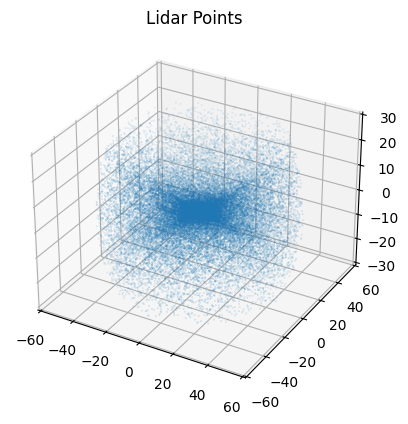

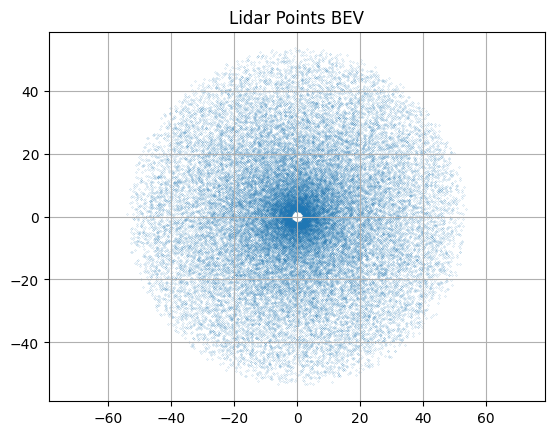

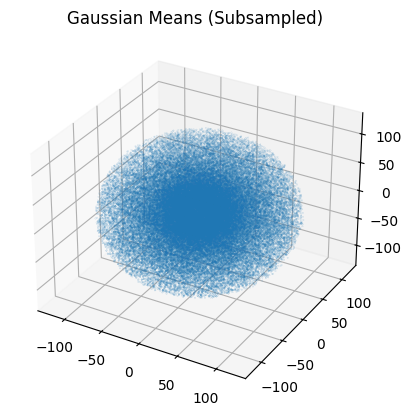

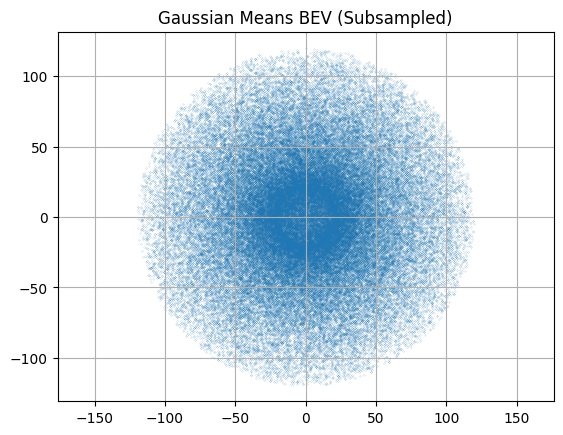

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc_xyz[...,0].cpu(), pc_xyz[...,1].cpu(), pc_xyz[...,2].cpu(), s=0.01)
ax.set_title("Lidar Points")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pc_xyz[...,0].cpu(), pc_xyz[...,1].cpu(), s=0.01)
ax.set_title("Lidar Points BEV")
ax.axis('equal')
ax.grid("on")
plt.show()

sub_sample_means_idx = torch.randint(0, N, (C, 100_000), device=DEVICE)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(means[sub_sample_means_idx,0].cpu(), means[sub_sample_means_idx,1].cpu(), means[sub_sample_means_idx,2].cpu(), s=0.01)
ax.set_title("Gaussian Means (Subsampled)")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(means[sub_sample_means_idx,0].cpu(), means[sub_sample_means_idx,1].cpu(), s=0.01)
ax.set_title("Gaussian Means BEV (Subsampled)")
ax.axis('equal')
ax.grid("on")
plt.show()

### Prepare data for rasterization

Before rasterization, we need to put the lidar points we want to render into a suitable format. Similar to how Gaussians are assigned to tiles, we assign the lidar points to tiles. The resulting `raster_pts` serves as a lookup during rasterization, where the thread can check the exact azimuth, elevation and rolling shutter offset time for the point to render. 

The tiles should be at most 256 "pixels", but don't have to be square.

Note that if more than 256 lidar points fall into the same tile, some of them will be ignored currently. During evaluation, you can account for this by creating two `raster_pts`, where the overflowing points end up in the second `raster_pts`. The rasterization code allows for batching, so this introduces little overhead. During training, shuffling the points is an effective strategy to use all of the points for supervision eventually.

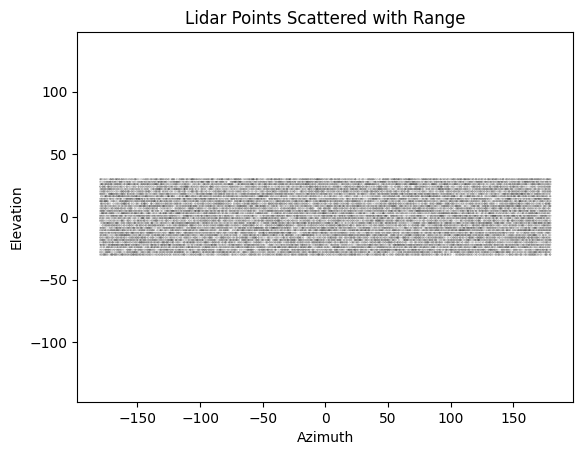

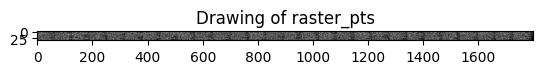

In [5]:
# Generate raster_pts from the point cloud
import math
from gsplat.cuda._wrapper import map_points_to_lidar_tiles, points_mapping_offset_encode, populate_image_from_points

# Define tiling settings
tile_width = 64 # each tile is 64 beams wide
tile_height = 4 # each tile is 4 beams high
# Boundary points for the tiles in the elevation direction
elevation_boundaries = torch.cat(
                [
                    elevations[0:1] - 1.0,
                    (
                        elevations[tile_height::tile_height]
                        + elevations[tile_height - 1 : -1 : tile_height]
                    )
                    / 2,
                    elevations[-1:] + 1.0,
                ]
            )

# Map points to tiles
points_tile_ids, flatten_ids = map_points_to_lidar_tiles(
        points2d=point_cloud[None,:,:2], elev_boundaries=elevation_boundaries, tile_azim_resolution=azimuth_resolution*tile_width, min_azim=min_azimuth
    )

tile_offsets = points_mapping_offset_encode(
            points_tile_ids,
            1,
            math.ceil((max_azimuth-min_azimuth)/(azimuth_resolution*tile_width)),
            len(elevations) // tile_height,
        )

# Generate raster_pts, used for lidar rendering
raster_pts = populate_image_from_points(  # [1, H, W, 5] (elev, azimuth, range, time, intensity)
                point_cloud[None],
                image_width=len(azimuths),
                image_height=len(elevations),
                tile_width=tile_width,
                tile_height=tile_height,
                tile_offsets=tile_offsets,
                flatten_id=flatten_ids,
            )

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(point_cloud[...,0].cpu(), point_cloud[...,1].cpu(), s=0.01, c=point_cloud[...,2].cpu(), cmap='gray')
ax.axis('equal')
ax.set_title("Lidar Points Scattered with Range")
ax.set_xlabel("Azimuth")
ax.set_ylabel("Elevation")
fig.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Drawing of raster_pts")
ax.imshow(raster_pts[0, ..., 2].cpu().numpy(), cmap='gray')

### Run rasterization

With Gaussians defined and lidar points in a suitable format we can run the lidar rasterization. Additional arguments to the `lidar_rasterization` are the linear and angular velocitiy of the sensor itself. 

In [6]:
# Run the rasterization
viewmats = torch.eye(4, device=DEVICE).unsqueeze(0) # world-to-lidar transform [1, 4, 4]
rendered_feat, rendered_alpha, alpha_sum_until_points, meta_info = lidar_rasterization(
    means=means,
    quats=quats,
    scales=scales,
    opacities=opacities,
    lidar_features=features.unsqueeze(0),
    velocities=velocities,
    viewmats=viewmats,
    raster_pts=raster_pts[..., :4],
    tile_elevation_boundaries=elevation_boundaries.clone(),
    min_azimuth=min_azimuth,
    max_azimuth=max_azimuth,
    min_elevation=min_elevation,
    max_elevation=max_elevation,
    n_elevation_channels=n_elevation_channels,
    azimuth_resolution=azimuth_resolution,
    tile_width=tile_width,
    tile_height=tile_height,
)
rendered_expected_depth = rendered_feat[...,-1]
rendered_median_depth = meta_info['median_depths']
rendered_feat = rendered_feat[..., :-1] # remove the depth channel

valid_pixels = (rendered_alpha > 0).any(dim=-1)
valid_raster_pts = raster_pts[valid_pixels]
valid_rendered_feat = rendered_feat[valid_pixels]
valid_rendered_expected_depth = rendered_expected_depth[valid_pixels]
valid_rendered_median_depth = rendered_median_depth[valid_pixels].squeeze(-1)
pred_points_spherical = torch.cat([valid_raster_pts[..., :2], valid_rendered_expected_depth[:,None]], dim=-1) # (n_valid_points, 3)
pred_points_xyz_expected_depth = torch.stack([
    torch.cos(pred_points_spherical[...,1].deg2rad()) * torch.cos(pred_points_spherical[...,0].deg2rad()) * pred_points_spherical[...,2],
    torch.cos(pred_points_spherical[...,1].deg2rad()) * torch.sin(pred_points_spherical[...,0].deg2rad()) * pred_points_spherical[...,2],
    torch.sin(pred_points_spherical[...,1].deg2rad()) * pred_points_spherical[...,2]
], dim=-1) # (n_valid_points, 3)
pred_points_xyz_median_depth = torch.stack([
    torch.cos(pred_points_spherical[...,1].deg2rad()) * torch.cos(pred_points_spherical[...,0].deg2rad()) * valid_rendered_median_depth,
    torch.cos(pred_points_spherical[...,1].deg2rad()) * torch.sin(pred_points_spherical[...,0].deg2rad()) * valid_rendered_median_depth,
    torch.sin(pred_points_spherical[...,1].deg2rad()) * valid_rendered_median_depth
], dim=-1) # (n_valid_points, 3)

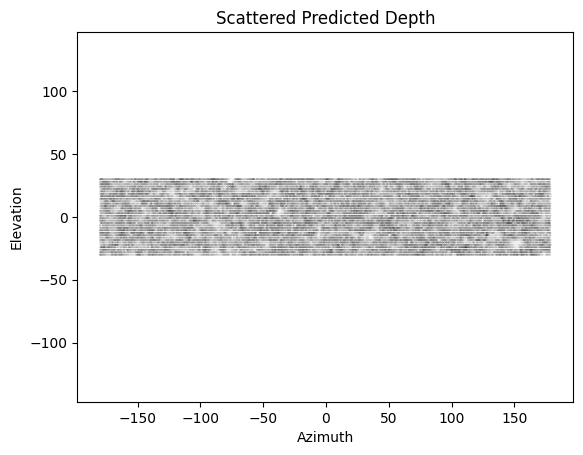

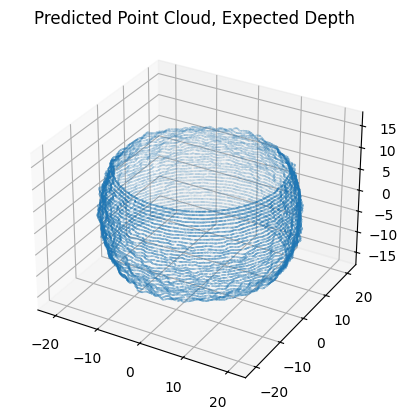

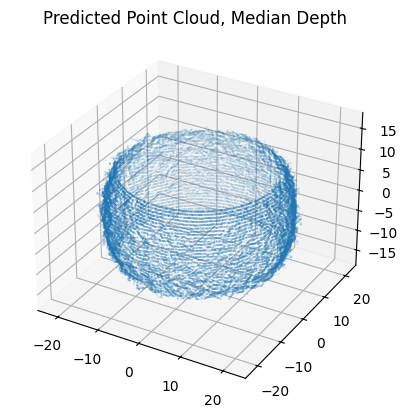

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Scattered Predicted Depth")
ax.scatter(pred_points_spherical[...,0].cpu(), pred_points_spherical[...,1].cpu(), s=0.01, c=pred_points_spherical[...,2].cpu(), cmap='gray')
ax.axis('equal')
ax.set_xlabel("Azimuth")
ax.set_ylabel("Elevation")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pred_points_xyz_expected_depth[...,0].cpu(), pred_points_xyz_expected_depth[...,1].cpu(), pred_points_xyz_expected_depth[...,2].cpu(), s=0.01)
ax.set_title("Predicted Point Cloud, Expected Depth")
ax.axis('equal')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pred_points_xyz_median_depth[...,0].cpu(), pred_points_xyz_median_depth[...,1].cpu(), pred_points_xyz_median_depth[...,2].cpu(), s=0.01)
ax.set_title("Predicted Point Cloud, Median Depth")
ax.axis('equal')
plt.show()